## Batch Evaluation
Set the folder parameter. Get an anaysis about all included batch evals

In [13]:
# import
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import json
import os
import pathlib

#set path to folder
folder = "../../../eval-results/_server-results/test8_1"
net_analysis = "../../../eval-results/_server-results/net-BP-birth/net.eval" 

In [16]:
#fetch data 
dir_list = next(os.walk(folder))[1]
dfs = []
#merge all 
for subfolder in dir_list:
    #print(subfolder)
    evalFile = folder +"/" + subfolder +"/aggRetrospectiveResults.eval"
    confFile = folder +"/" + subfolder +"/config.log"
    if os.path.exists(evalFile):
        df = pd.read_csv(evalFile ,encoding="ISO-8859-1", skipinitialspace=True)
        with open(confFile) as json_file:
            conf = json.load(json_file)
        #add config information to dataframe 
        df['matcher'] = conf['matcher']['ilp'] + " - " + conf['matcher']['profile'] +" - " + str(conf['matcher']['word-sim']) + " - sim-weight=" + str(conf['matcher']['sim-weight']) + " - match-postprocessing=" + str(conf['matcher']['postprocessing-thresh']) 
        df['matcher_wo_weight'] = conf['matcher']['ilp'] + " - " + conf['matcher']['profile'] +" - " + str(conf['matcher']['word-sim']) + " - match-postprocessing=" + str(conf['matcher']['postprocessing-thresh']) 
        df['complex-matches'] = conf['matcher']['complex matches']
        df['profile'] = conf['matcher']['profile']
        df['ilp'] =  conf['matcher']['ilp']
        df['word-sim'] =  conf['matcher']['word-sim']
        df['sim-weight'] = conf['matcher']['sim-weight']
        df['matcher-postprocessing-threshold'] = conf['matcher']['postprocessing-thresh']
        df['eval-postprocessing-threshold'] = conf['evaluation']['postprocessing-thresh']
        
        #df.set_index(['Name','matcher'])
        dfs.append(df)
        
df_combined = pd.concat(dfs)

#convert time
df_combined['OVERALL TIME'] = df_combined['OVERALL TIME'].map(lambda x: x / 1000000000.)
df_combined['BP TIME'] = df_combined['BP TIME'].map(lambda x: x / 1000000000.)
df_combined['LABEL-SIM TIME'] = df_combined['LABEL-SIM TIME'].map(lambda x: x / 1000000000.)
df_combined['LP TIME'] = df_combined['LP TIME'].map(lambda x: x / 1000000000.)

#extend with net information stored in net_analysis
df_nets = pd.read_csv(net_analysis ,encoding="ISO-8859-1", skipinitialspace=True)
#df_nets.set_index('Name')

def net1adder(row):
    #get net names
    if row['Name'] != "Aggregated (MICRO)" and row['Name'] != "Aggregated (MACRO)":
        return row['Name'].split('-')[0].replace(".pnml","")
    else:
        return 0
def net2adder(row):        
    if row['Name'] != "Aggregated (MICRO)" and row['Name'] != "Aggregated (MACRO)":
        return row['Name'].split('-')[1].split('.')[0].replace(".pnml","")
    else: 
        return 0
    
def pnml_remover(row):
    #get net names
    if row['Name'] != "Aggregated (MICRO)" and row['Name'] != "Aggregated (MACRO)":
        return row['Name'].replace(".pnml","").replace(".rdf","")
    else:
        return row['Name']

def net1NonTaus(row):
    if row['Name'] != "Aggregated (MICRO)" and row['Name'] != "Aggregated (MACRO)":
        return df_nets.at[row['net1'],'nNonSilentTransitions'] 
    else:
        return 0
def net2NonTaus(row):
    if row['Name'] != "Aggregated (MICRO)" and row['Name'] != "Aggregated (MACRO)":
        return df_nets.at[row['net2'],'nNonSilentTransitions'] 
    else:
        return 0
def sumNonTaus(row):    
    if row['Name'] != "Aggregated (MICRO)" and row['Name'] != "Aggregated (MACRO)":
        return row['net1NonTaus'] + row['net2NonTaus']
    else:
        return 0
    
df_combined['net1'] = df_combined.apply(lambda row: net1adder(row), axis=1)
df_combined['net2'] = df_combined.apply(lambda row: net2adder(row), axis=1)
df_combined['net1NonTaus'] = df_combined.apply(lambda row: net1NonTaus(row), axis=1)
df_combined['net2NonTaus'] = df_combined.apply(lambda row: net2NonTaus(row), axis=1)
df_combined['sumNonTaus'] = df_combined.apply(lambda row: sumNonTaus(row), axis=1)
df_combined['Name'] = df_combined.apply(lambda row: pnml_remover(row), axis=1)

#df_combined[:10]

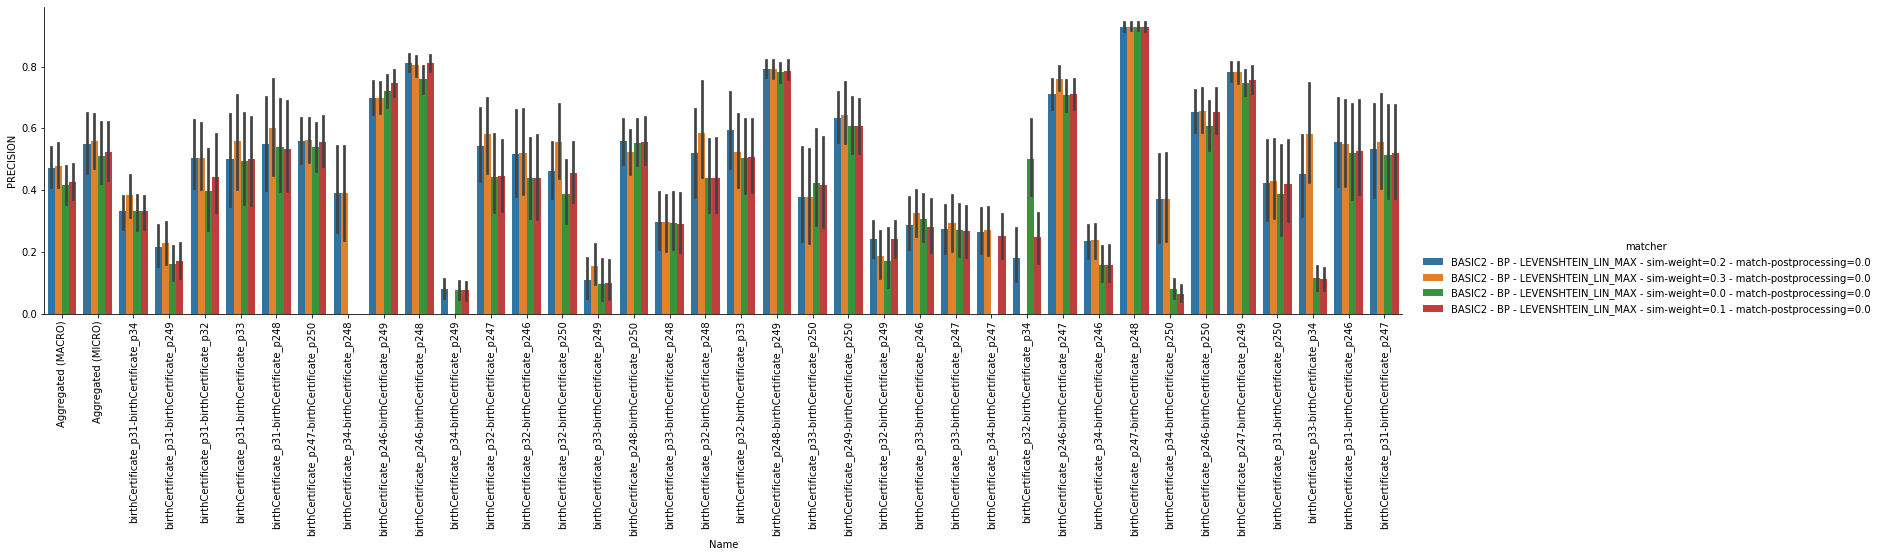

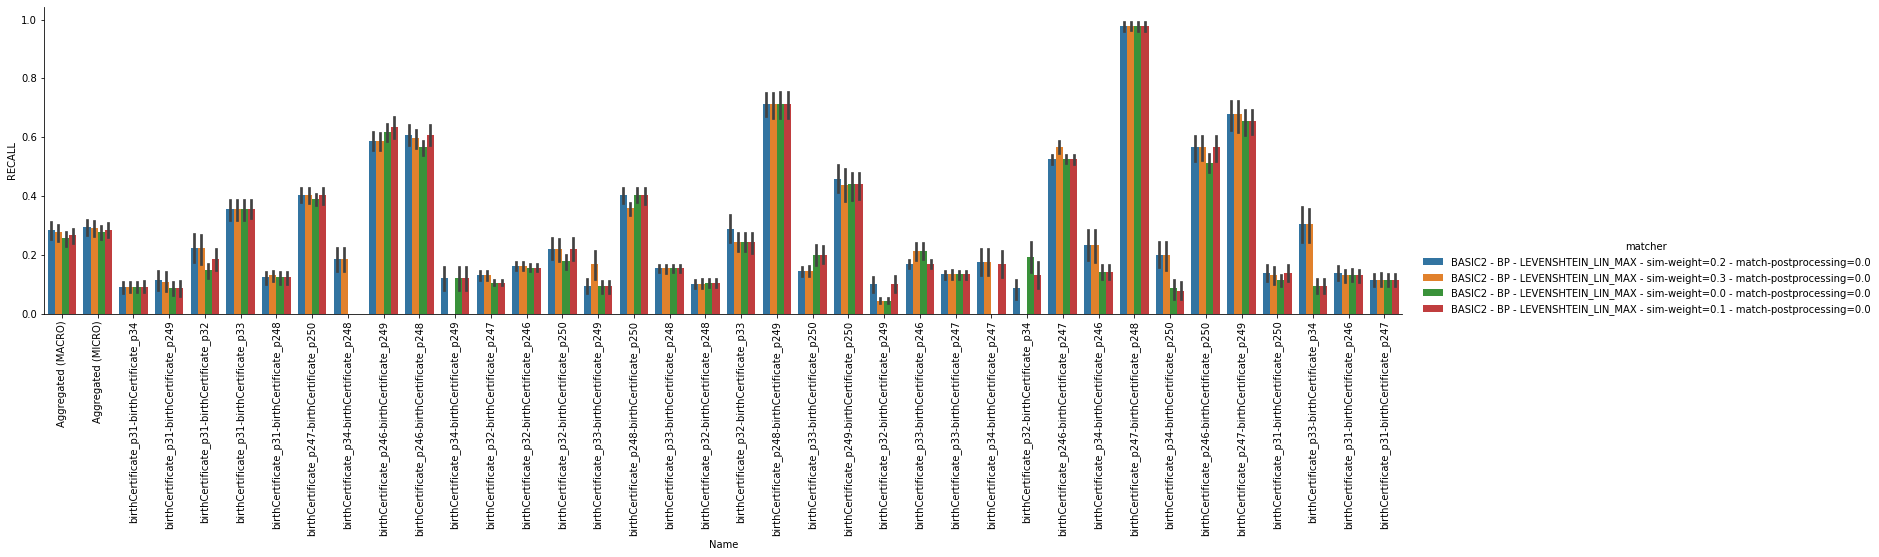

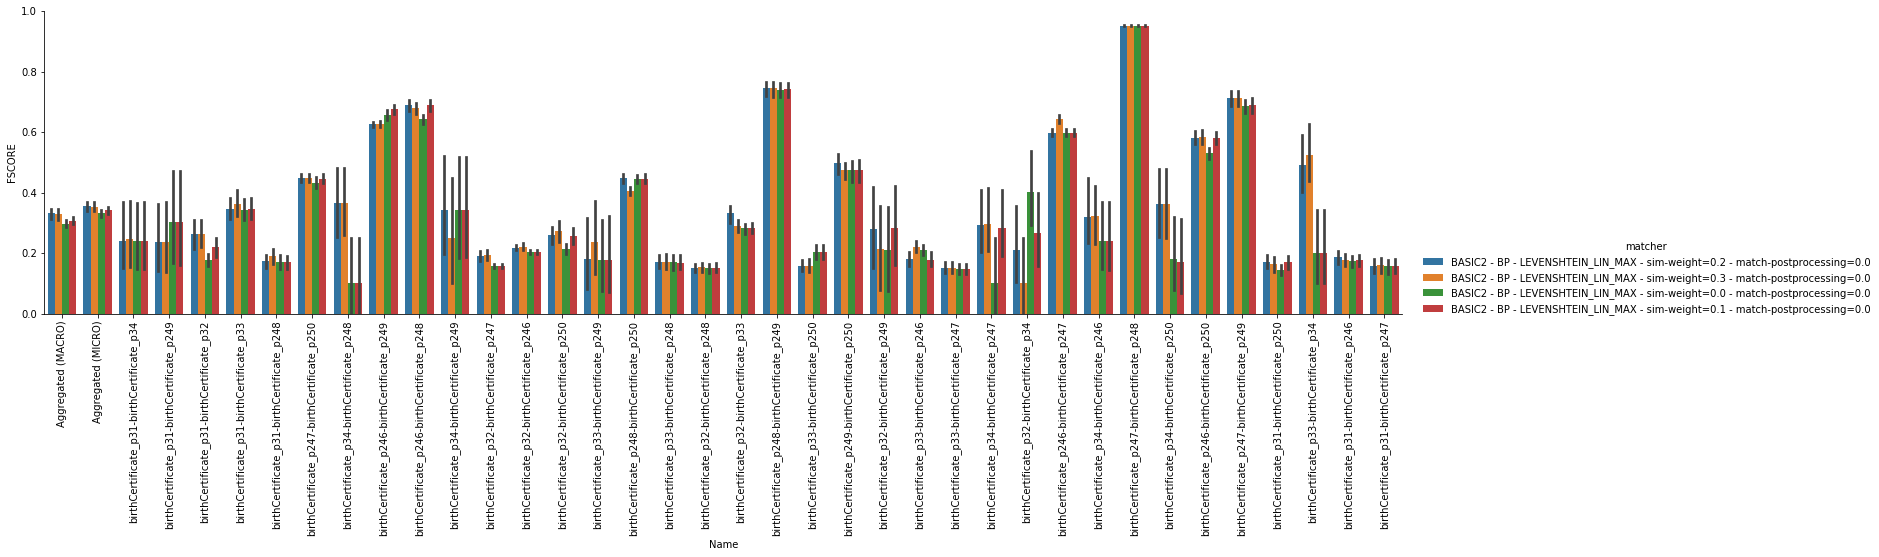

In [17]:
#BASIC VISUALIZATION

# visualize Precision 
g = sns.catplot(x="Name", y="PRECISION", hue="matcher", kind="bar", data=df_combined,  height=5, aspect=4);
g.set_xticklabels(rotation=90)

# Visualize Recall
g = sns.catplot(x="Name", y="RECALL", hue="matcher", kind="bar", data=df_combined,  height=5, aspect=4);
g.set_xticklabels(rotation=90)

# Visualize FSCORE
g = sns.catplot(x="Name", y="FSCORE", hue="matcher", kind="bar", data=df_combined,  height=5, aspect=4);
g.set_xticklabels(rotation=90)


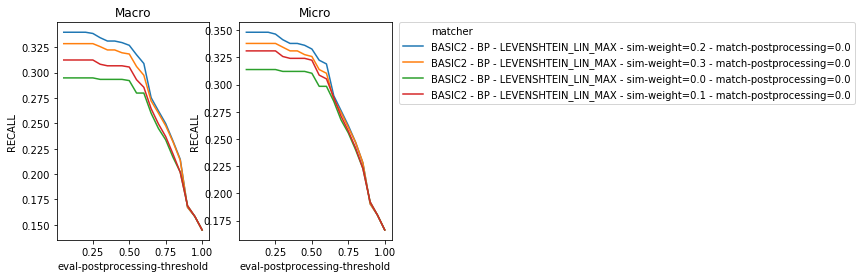

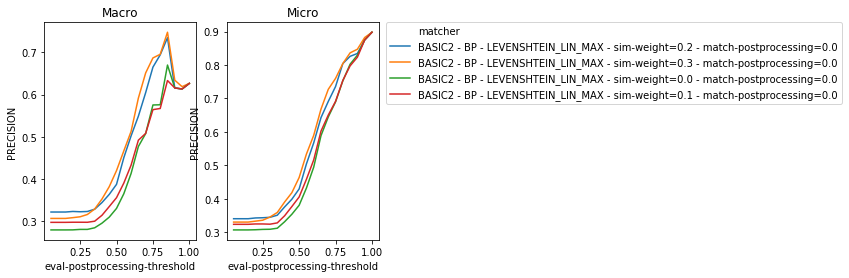

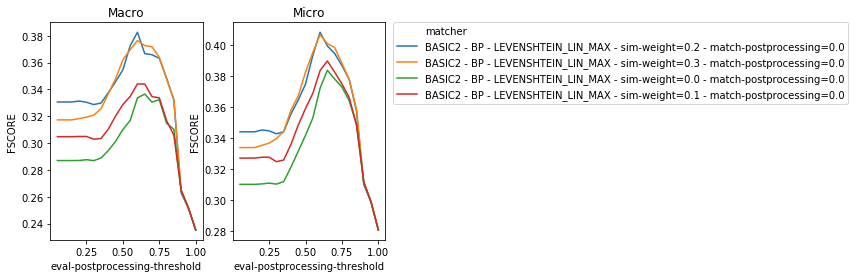

In [18]:
# Avg Precisision Recall Fscore over postprocessing threshold
df_macro_avg = df_combined[df_combined.Name == "Aggregated (MACRO)"]
df_micro_avg = df_combined[df_combined.Name == "Aggregated (MICRO)"]

fig, (ax1, ax2) = plt.subplots(1,2)
sns.lineplot(x="eval-postprocessing-threshold", y="RECALL", hue="matcher", data=df_macro_avg, ax = ax1);
ax1.set_title("Macro")
ax1.get_legend().remove()
sns.lineplot(x="eval-postprocessing-threshold", y="RECALL", hue="matcher", data=df_micro_avg, ax = ax2);
ax2.set_title("Micro")
ax2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

fig, (ax1, ax2) = plt.subplots(1,2)
sns.lineplot(x="eval-postprocessing-threshold", y="PRECISION", hue="matcher", data=df_macro_avg, ax = ax1);
ax1.set_title("Macro")
ax1.get_legend().remove()
sns.lineplot(x="eval-postprocessing-threshold", y="PRECISION", hue="matcher", data=df_micro_avg, ax = ax2);
ax2.set_title("Micro")
ax2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

fig, (ax1, ax2) = plt.subplots(1,2)
sns.lineplot(x="eval-postprocessing-threshold", y="FSCORE", hue="matcher", data=df_macro_avg, ax = ax1);
ax1.set_title("Macro")
ax1.get_legend().remove()
sns.lineplot(x="eval-postprocessing-threshold", y="FSCORE", hue="matcher", data=df_micro_avg, ax = ax2);
ax2.set_title("Micro")
ax2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()


/Users/dominikhuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


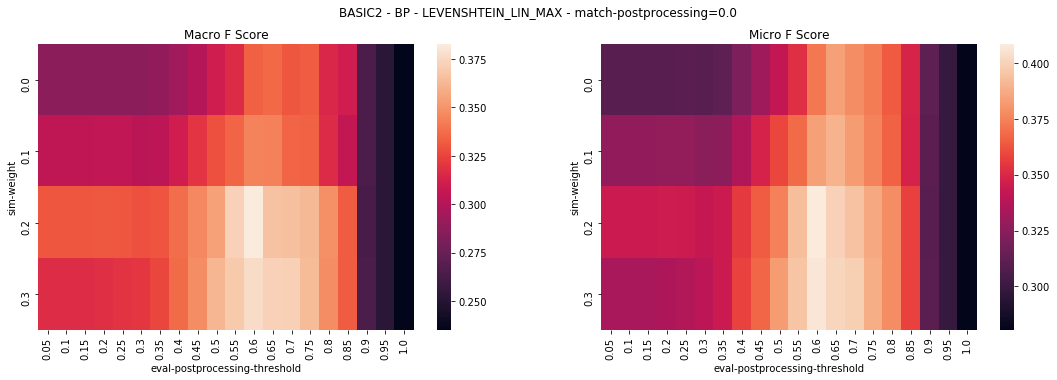

In [5]:
#avg fscore for each matcher depending on A) the sim weight B) the 
df_macro_avg = df_combined[df_combined.Name == "Aggregated (MACRO)"]
df_micro_avg = df_combined[df_combined.Name == "Aggregated (MICRO)"]

matchers = set(df_macro_avg["matcher_wo_weight"].values)
for m in matchers:
    df_macro_avg_fscore = df_macro_avg[df_macro_avg["matcher_wo_weight"] == m].pivot("sim-weight", "eval-postprocessing-threshold", "FSCORE")
    df_micro_avg_fscore = df_micro_avg[df_micro_avg["matcher_wo_weight"] == m].pivot("sim-weight", "eval-postprocessing-threshold", "FSCORE")
    
    fig, (ax1, ax2) = plt.subplots(1,2)
    fig.set_size_inches(18.5, 5.25)

    sns.heatmap(df_macro_avg_fscore, ax = ax1)
    ax1.set_title("Macro F Score")
    sns.heatmap(df_micro_avg_fscore, ax = ax2)
    ax2.set_title("Micro F Score")
    fig.suptitle(m)
    fig.show()


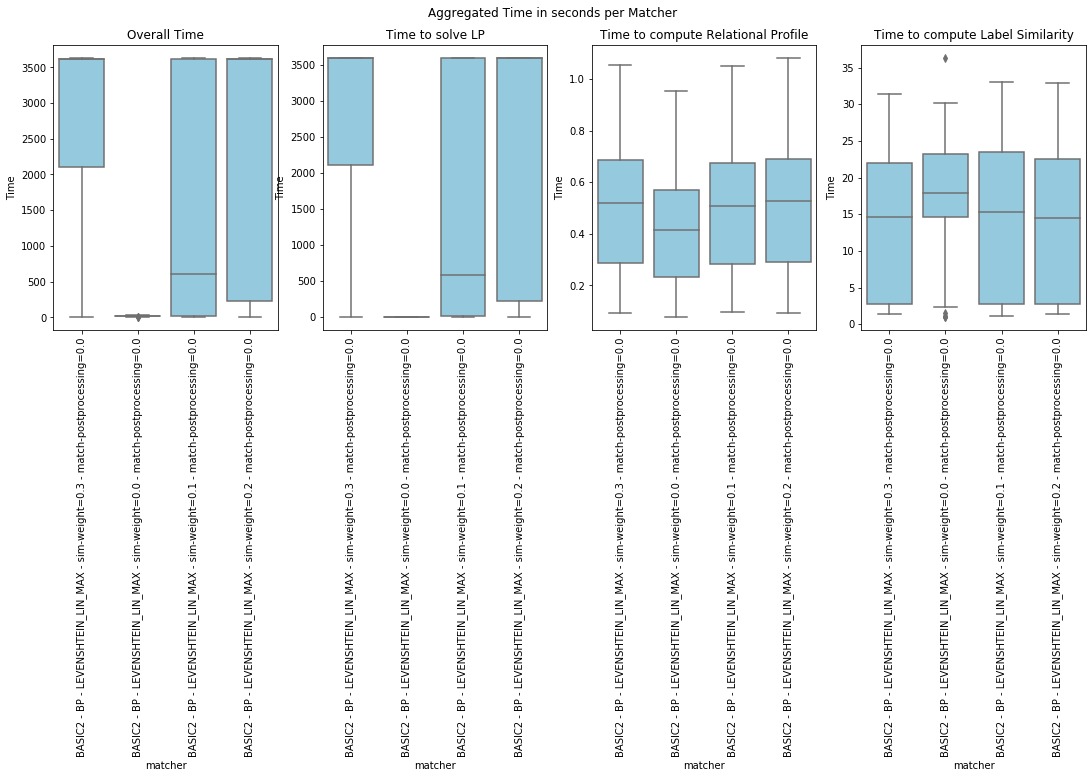

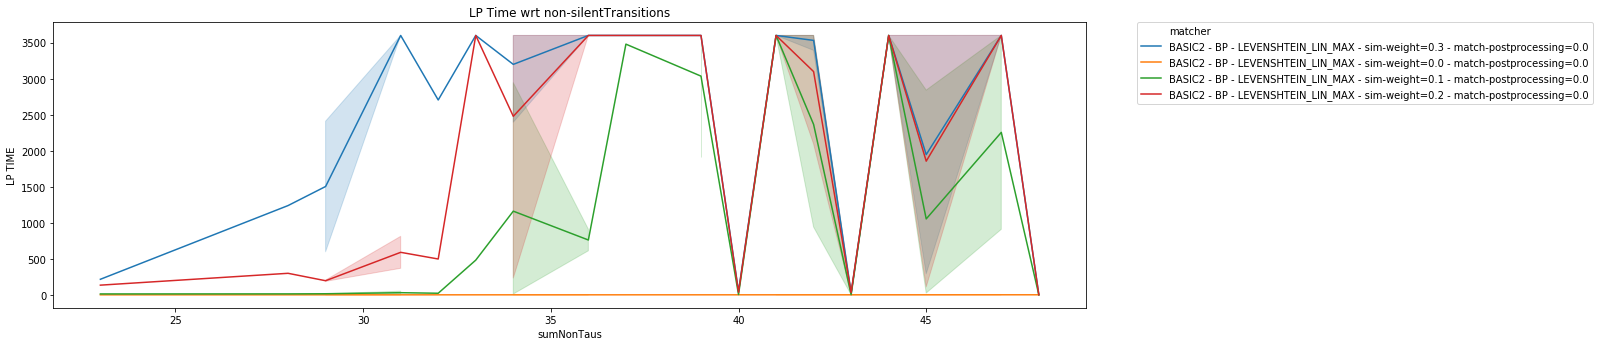

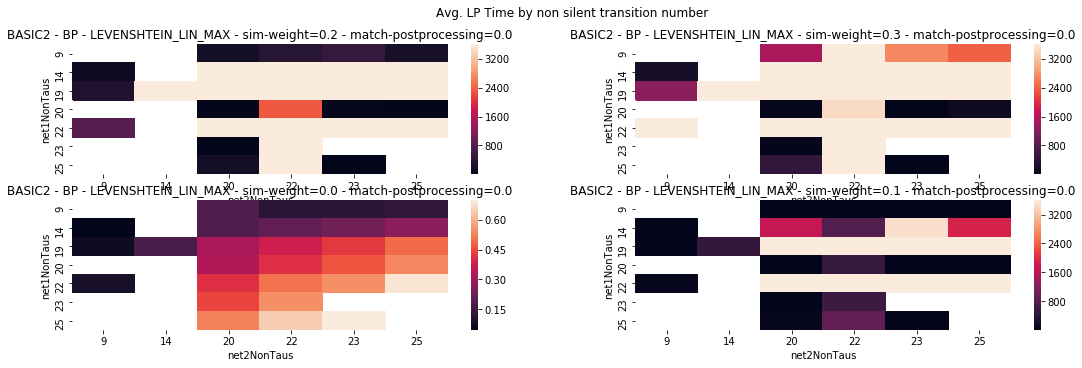

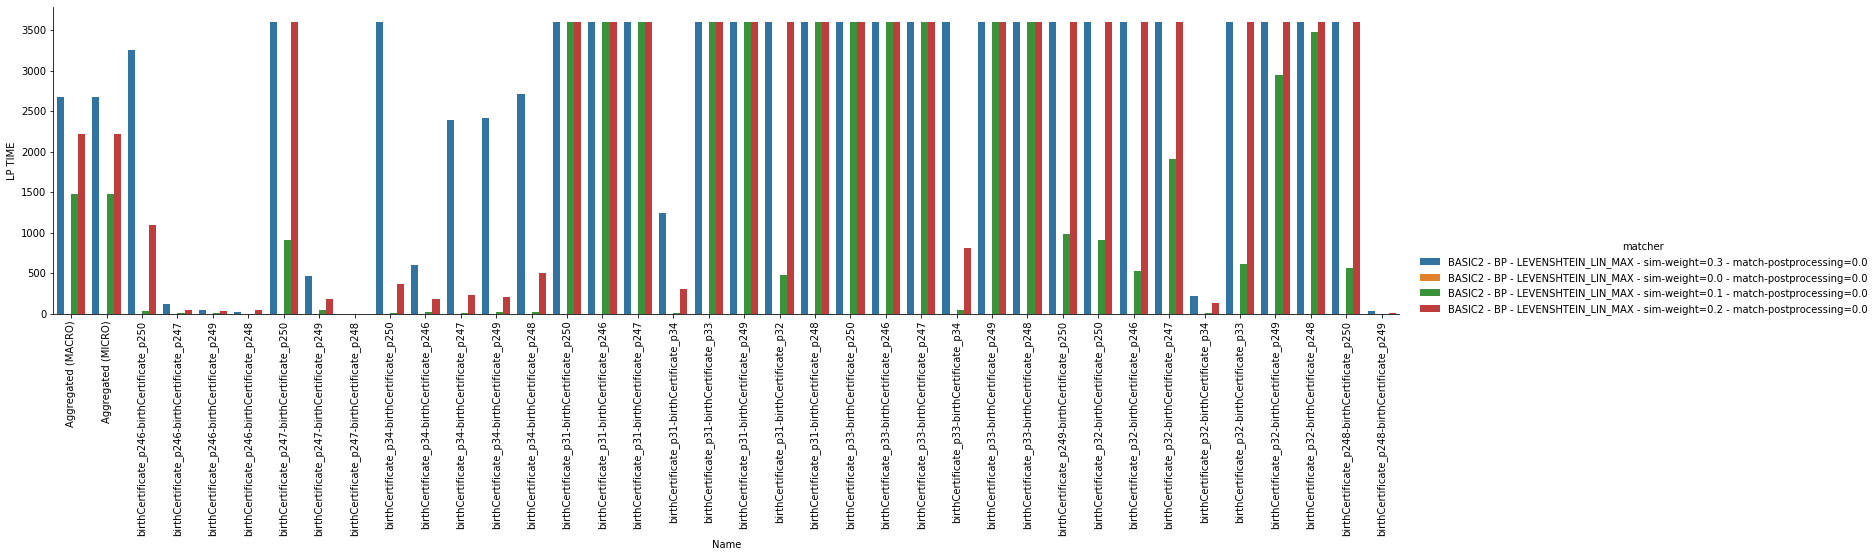

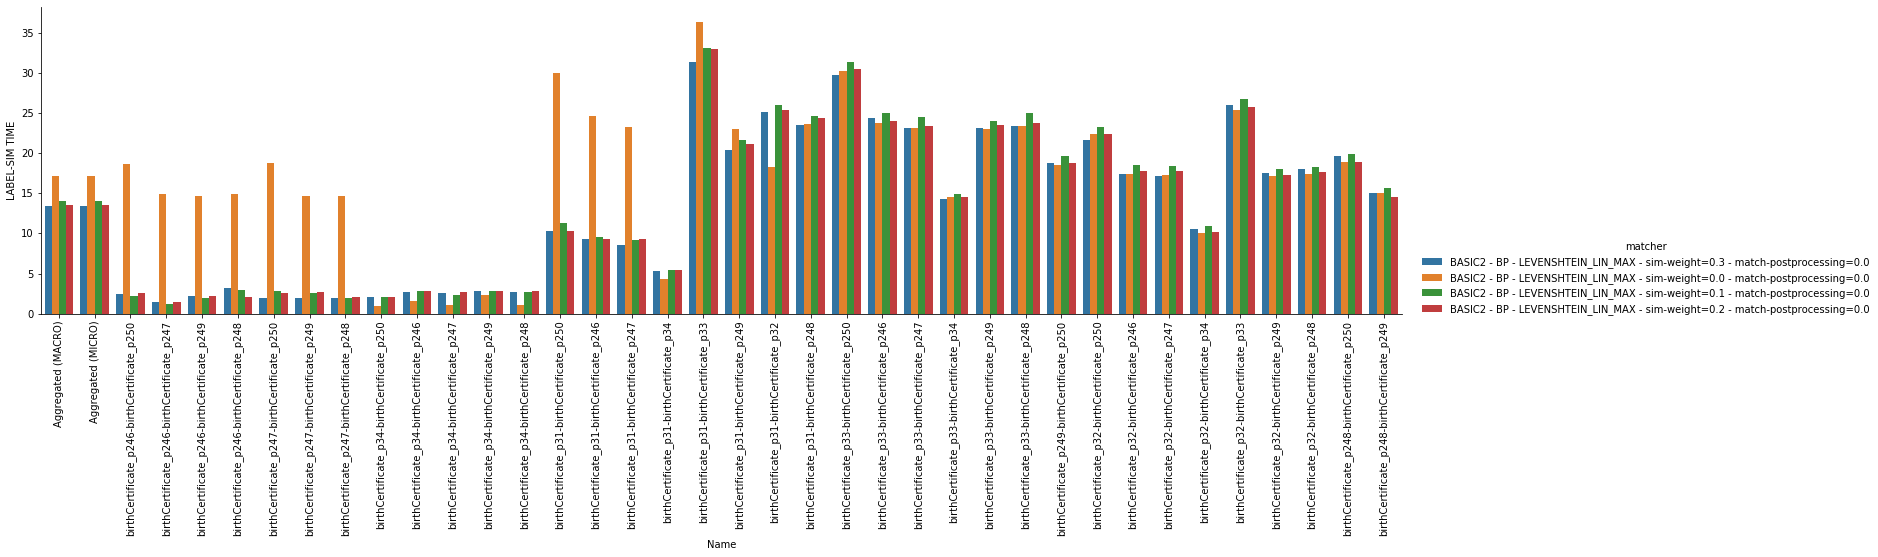

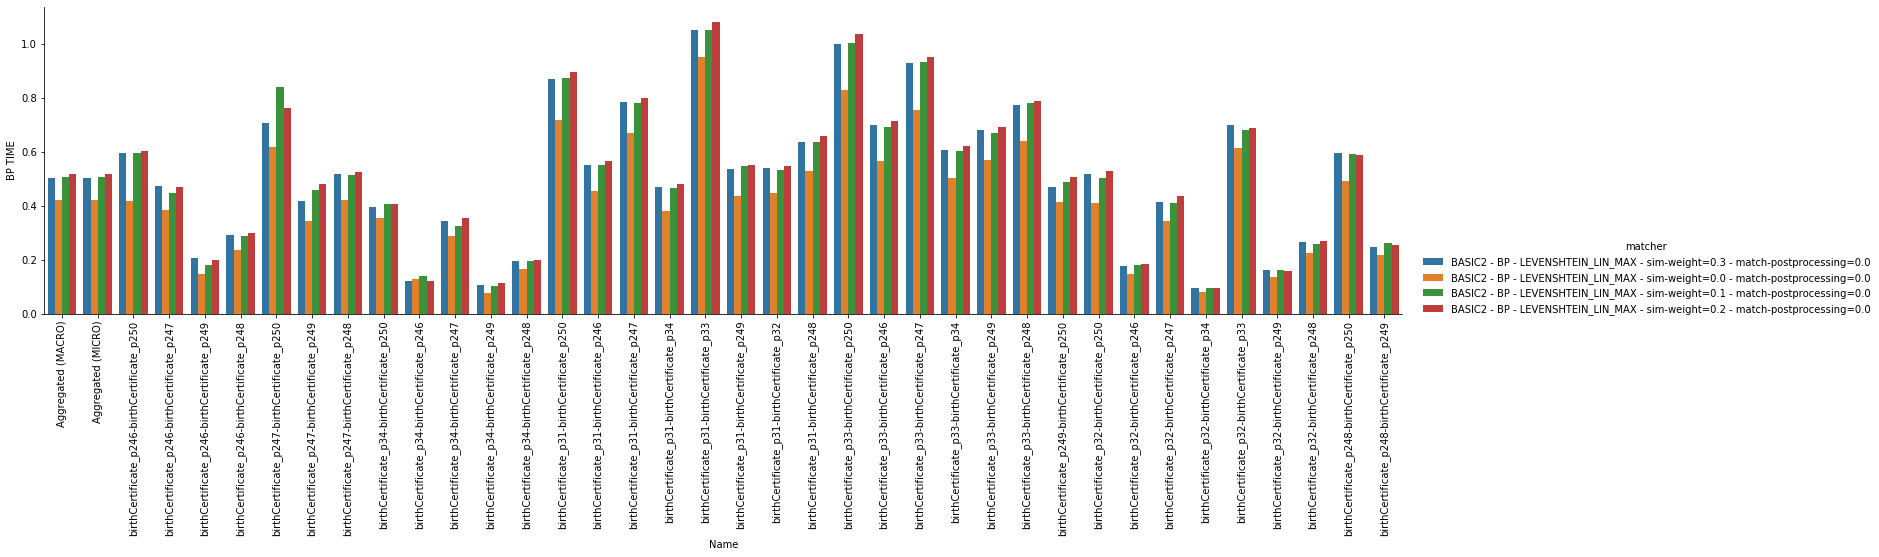

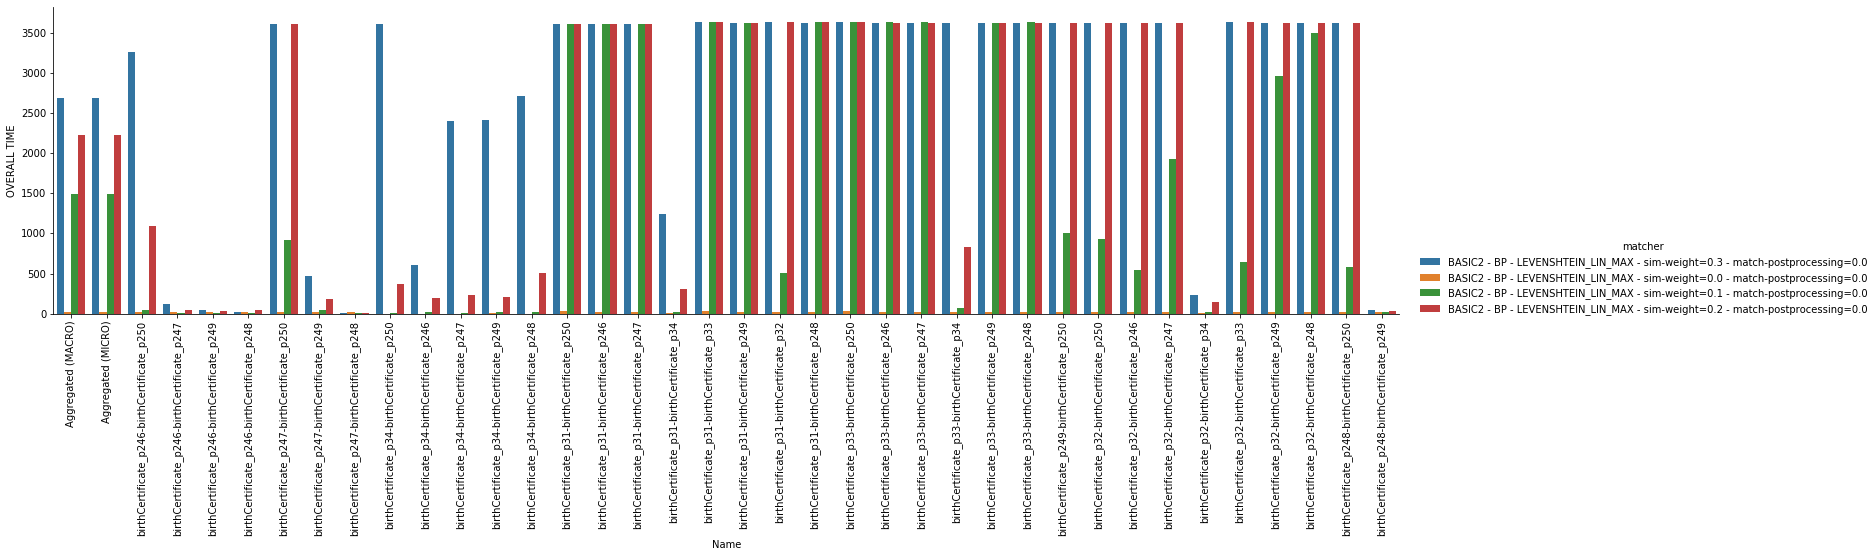

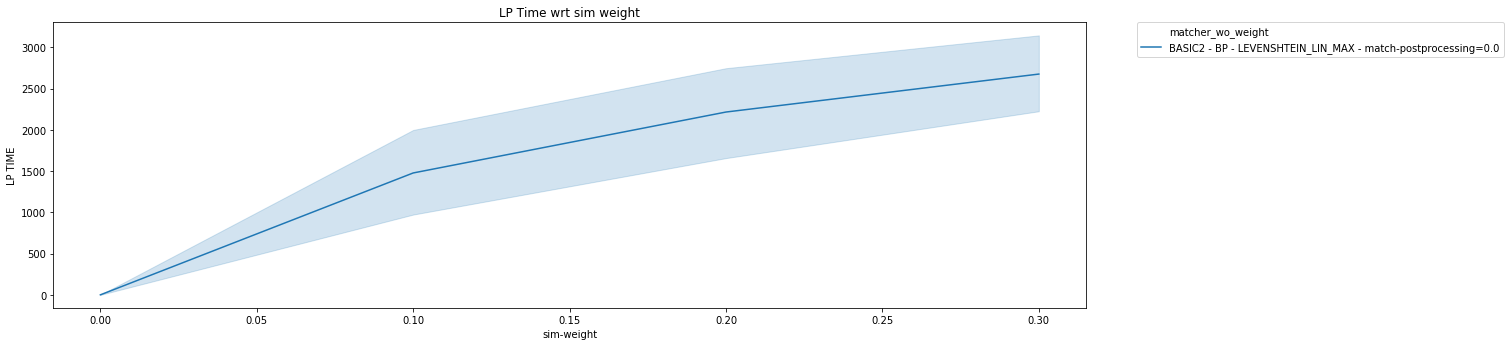

In [12]:
#runtime analysis
df_ = df_combined[df_combined["Name"] != "Aggregated (MICRO)"]
df_ = df_[df_["Name"] != "Aggregated (MACRO)"]

#boxplots for each matcher
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4)
fig.set_size_inches(18.5, 5.25)
sns.boxplot(x="matcher", y="OVERALL TIME", data=df_, ax=ax1, color='skyblue')
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=90)
ax1.set_title("Overall Time")
ax1.set_ylabel("Time")
sns.boxplot(x="matcher", y="LP TIME", data=df_, ax=ax2, color='skyblue')
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=90)
ax2.set_title("Time to solve LP")
ax2.set_ylabel("Time")
sns.boxplot(x="matcher", y="BP TIME", data=df_, ax=ax3, color='skyblue')
ax3.set_xticklabels(ax3.get_xticklabels(),rotation=90)
ax3.set_title("Time to compute Relational Profile")
ax3.set_ylabel("Time")
sns.boxplot(x="matcher", y="LABEL-SIM TIME", data=df_, ax=ax4, color='skyblue')
ax4.set_xticklabels(ax4.get_xticklabels(),rotation=90)
ax4.set_title("Time to compute Label Similarity")
ax4.set_ylabel("Time")
fig.suptitle("Aggregated Time in seconds per Matcher")

# sum of tau transitions analysis
fig, (ax1) = plt.subplots(1,1)
fig.set_size_inches(18.5, 5.25)
sns.lineplot(x="sumNonTaus", y="LP TIME", hue="matcher", data=df_, ax=ax1);
plt.title("LP Time wrt non-silentTransitions")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#heatmap time
matchers = list(set(df_["matcher"].values))
fig, ax = plt.subplots(int((len(matchers)+1)/2),2)
axli = ax.flatten()
fig.set_size_inches(18.5, 5.25)
fig.suptitle("Avg. LP Time by non silent transition number")
for i,m in enumerate(matchers, start=0):
    df_pivot = pd.pivot_table(df_[df_['matcher'] == m], values='LP TIME', index=['net1NonTaus'], columns=['net2NonTaus'],aggfunc=np.mean)
    sns.heatmap(df_pivot, ax = axli[i])
    axli[i].set_title(m)

#Visualize Runtime
g = sns.catplot(x="Name", y="LP TIME", hue="matcher", kind="bar", data=df_combined,  height=5, aspect=4);
g.set_xticklabels(rotation=90)

#Visualize Runtime
g = sns.catplot(x="Name", y="LABEL-SIM TIME", hue="matcher", kind="bar", data=df_combined,  height=5, aspect=4);
g.set_xticklabels(rotation=90)

#Visualize Runtime
g = sns.catplot(x="Name", y="BP TIME", hue="matcher", kind="bar", data=df_combined,  height=5, aspect=4);
g.set_xticklabels(rotation=90)

#Visualize Runtime
g = sns.catplot(x="Name", y="OVERALL TIME", hue="matcher", kind="bar", data=df_combined,  height=5, aspect=4);
g.set_xticklabels(rotation=90)

# time wrt behavioral share
fig, (ax1) = plt.subplots(1,1)
fig.set_size_inches(18.5, 5.25)
sns.lineplot(x="sim-weight", y="LP TIME", hue="matcher_wo_weight", data=df_, ax=ax1);
plt.title("LP Time wrt sim weight")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)